# Regression Problem

## Attribute Information
1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

Here I have added the sub_metering_1, sub_metering_2, sub_metering_3 columns to have one target column i.e., metering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pd
import seaborn as sns
from EDA import data
from standard_scalar import standardization
from sklearn.model_selection import train_test_split
from traintest_split import split
from connection_db import database
from Linear_regression import lr
from sklearn.linear_model import LinearRegression
from ridge_lasso_elasticnet import regularization
from Regression_evaluation import evaluation_metrics
from svr import support_vector_regressor

In [2]:
#loading the dataset
path = r"C:\Users\Thanmai\INEURON\Electricity_consumption.xlsx"
obj = data()
df = obj.load_data(path)
# Dropping Date & Time columns
df = df.drop('Date', axis =1)
df = df.drop('Time', axis = 1)
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,metering
0,4.216,0.418,234.84,18.4,18.0
1,5.360,0.436,233.63,23.0,17.0
2,5.374,0.498,233.29,23.0,19.0
3,5.388,0.502,233.74,23.0,18.0
4,3.666,0.528,235.68,15.8,18.0
...,...,...,...,...,...
21991,2.574,0.132,241.89,10.6,0.0
21992,2.576,0.132,242.06,10.6,0.0
21993,2.586,0.134,242.61,10.6,0.0
21994,2.648,0.212,241.93,11.0,0.0


In [3]:
df.isnull().sum()

Global_active_power      4
Global_reactive_power    4
Voltage                  4
Global_intensity         4
metering                 4
dtype: int64

We can see that there are null values in the dataset.
Let's handle the null values by imputing them with most frequent value.

In [4]:
# Checking for null values and replacing the null values with mode
imputed_df = obj.check_null(df)

C:\Users\Thanmai\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Let's check for the null values again

In [5]:
imputed_df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
metering                 0
dtype: int64

We can see that we have successfully imputed the null values.

In [6]:
# analysis of each column in dataset
obj.data_analysis(imputed_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21996 entries, 0 to 21995
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    21996 non-null  float64
 1   Global_reactive_power  21996 non-null  float64
 2   Voltage                21996 non-null  float64
 3   Global_intensity       21996 non-null  float64
 4   metering               21996 non-null  float64
dtypes: float64(5)
memory usage: 859.3 KB
None
                         count        mean        std      min      25%  \
Global_active_power    21996.0    1.900987   1.418067    0.194    0.496   
Global_reactive_power  21996.0    0.131362   0.119910    0.000    0.000   
Voltage                21996.0  241.441245   3.915723  228.200  238.750   
Global_intensity       21996.0    8.028751   5.956245    0.800    2.200   
metering               21996.0   10.871204  14.654134    0.000    0.000   

                           50%

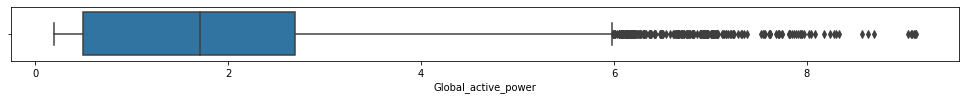

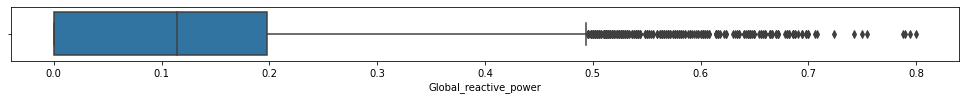

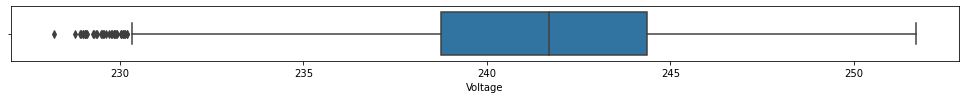

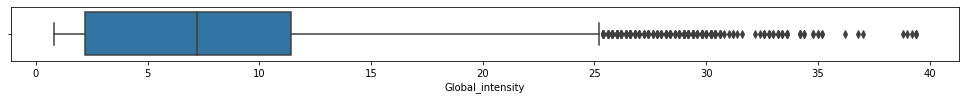

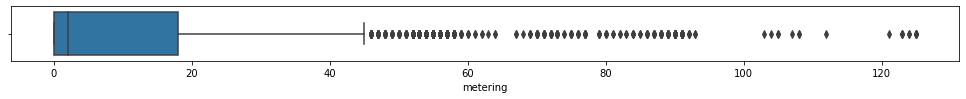

In [7]:
# Let's check for outliers
obj.outliers(imputed_df)

Even though there are outliers in the data, I don't want to manipulate the data. If we manipulate the outliers, there is a chance that we might loose some important data and that might effect the model.

Here i'm establishing the connection to import the cleaned dataset into mongodb.

In [8]:
# Loading imputed data to Mongodb and exporting the data for model building
obj2 = database()
path = 'C:/Users/Thanmai/INEURON/Project//Electricity_consumption_json.json'
database_name = 'Project'
table_name = 'Electricity_consumption'
obj2.connecting_mongodb(imputed_df, path, table_name, database_name)

Database(MongoClient(host=['thanmai-shard-00-01.oczr5.mongodb.net:27017', 'thanmai-shard-00-00.oczr5.mongodb.net:27017', 'thanmai-shard-00-02.oczr5.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-efvwgk-shard-0', tls=True), 'test')


I have successfully establised the connection and imported the cleaned data.
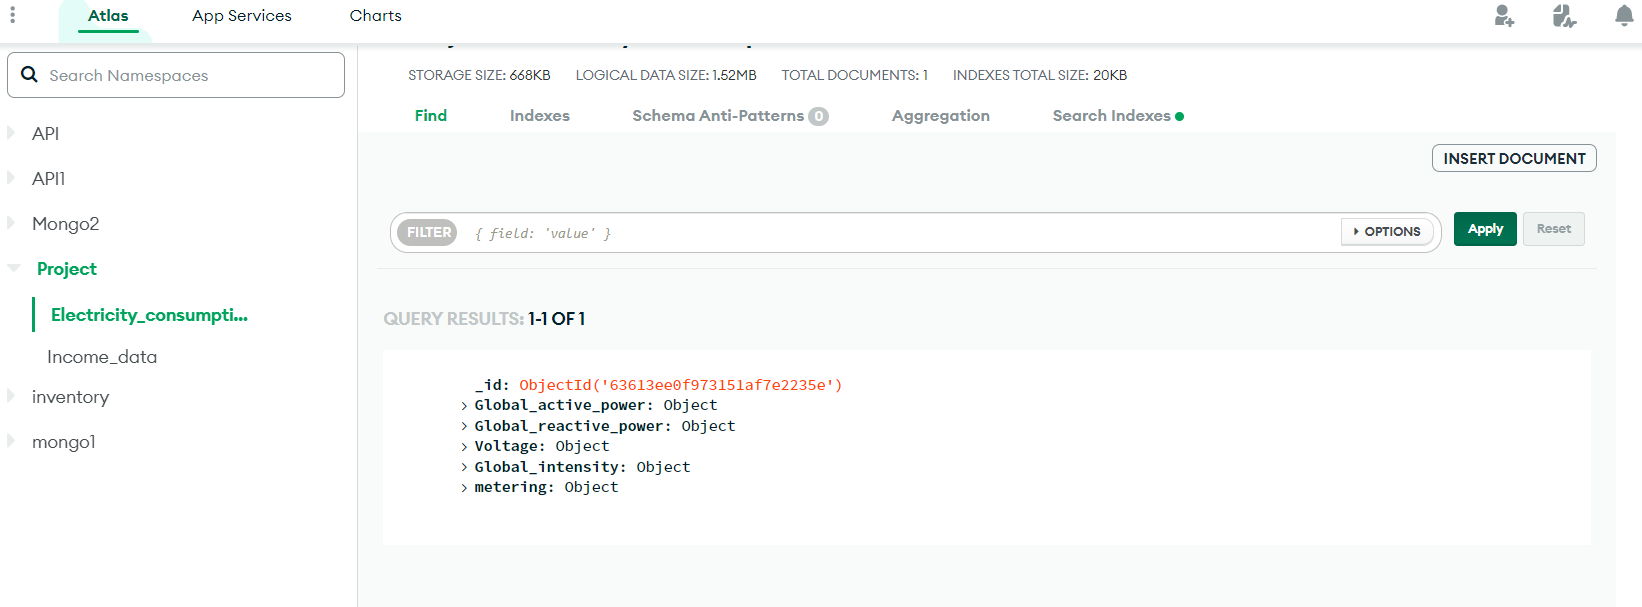
Now I have to fetch the data from database for model building.

In [9]:
data = obj2.fetch_data(table_name, database_name)

{'_id': ObjectId('63613ee0f973151af7e2235e'), 'Global_active_power': {'0': 4.216, '1': 5.36, '2': 5.374, '3': 5.388, '4': 3.666, '5': 3.52, '6': 3.702, '7': 3.7, '8': 3.668, '9': 3.662, '10': 4.448, '11': 5.412, '12': 5.224, '13': 5.268, '14': 4.054, '15': 3.384, '16': 3.27, '17': 3.43, '18': 3.266, '19': 3.728, '20': 5.894, '21': 7.706, '22': 7.026, '23': 5.174, '24': 4.474, '25': 3.248, '26': 3.236, '27': 3.228, '28': 3.258, '29': 3.178, '30': 2.72, '31': 3.758, '32': 4.342, '33': 4.512, '34': 4.058, '35': 2.472, '36': 2.79, '37': 2.624, '38': 2.772, '39': 3.74, '40': 4.928, '41': 6.052, '42': 6.752, '43': 6.474, '44': 6.308, '45': 4.464, '46': 3.396, '47': 3.09, '48': 3.73, '49': 2.308, '50': 2.388, '51': 4.598, '52': 4.524, '53': 4.202, '54': 4.472, '55': 2.852, '56': 2.928, '57': 2.94, '58': 2.934, '59': 2.926, '60': 3.452, '61': 4.87, '62': 4.868, '63': 4.866, '64': 3.176, '65': 2.92, '66': 2.93, '67': 2.912, '68': 2.608, '69': 2.714, '70': 3.538, '71': 6.072, '72': 4.536, '73': 

I have successfully exported the data, but the data is in json format. So, we have convert the json data to pandas dataframe to use the dataset for model building.

In [10]:
import pandas as pd
exported_df = pd.DataFrame(data)
exported_df = exported_df.drop('_id', axis = 1)
exported_df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,metering
0,4.216,0.418,234.84,18.4,18.0
1,5.360,0.436,233.63,23.0,17.0
2,5.374,0.498,233.29,23.0,19.0
3,5.388,0.502,233.74,23.0,18.0
4,3.666,0.528,235.68,15.8,18.0
...,...,...,...,...,...
21991,2.574,0.132,241.89,10.6,0.0
21992,2.576,0.132,242.06,10.6,0.0
21993,2.586,0.134,242.61,10.6,0.0
21994,2.648,0.212,241.93,11.0,0.0


I have successfully converted the json data to pandas dataframe.

Let's proceed further by performing train test split.

In [11]:
# Train Test Split
X = exported_df.drop('metering', axis = 1)
y = exported_df['metering']
obj3 = split()
X_train, X_test, y_train, y_test = obj3.data_split(X,y)

Let's check the length of the data.

In [12]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

15397 15397
6599 6599


In [13]:
# Standardization
obj4 = standardization()
X_train_transformed, X_test_transformed = obj4.standardize_data(X_train, X_test)

[[-0.86110121  0.05389919 -1.02883775 -0.84900193]
 [ 1.85073642 -0.4462731  -1.17249113  1.86356256]
 [ 1.23185231 -0.57965237 -0.10022125  1.19379355]
 ...
 [ 1.45971419  1.9712263  -0.52092044  1.42821271]
 [-0.17188936 -0.06280768  1.19265917 -0.01179067]
 [ 0.00533654 -0.26287659  0.49747942 -0.04527912]]


In [14]:
#Linear regression model 
obj5 = lr()
linear_reg_pred = obj5.linear_regression(X_train_transformed, y_train, X_test_transformed, y_test)
print("Actual vs Predicted Values of Linear regression Model")
dataset = pd.DataFrame({'Actual': y_test, 'Predicted': linear_reg_pred})
dataset.head(10)

Actual vs Predicted Values of Linear regression Model


,Actual,Predicted
3588,0.0,-0.785617
13549,0.0,12.150471
10823,0.0,12.326672
5331,18.0,6.844295
21697,0.0,15.476654
3515,1.0,-0.651502
17785,19.0,21.630335
10805,0.0,2.629006
15012,0.0,-0.787795
20401,37.0,24.237488


In [15]:
#Ridge regression
obj6 = regularization()
ridge_pred = obj6.ridge_regression(X_train_transformed, y_train, X_test_transformed, y_test)
print("Actual vs Predicted Values of Ridge regression Model")
dataset = pd.DataFrame({'Actual': y_test, 'Predicted': ridge_pred})
dataset.head(10)

Actual vs Predicted Values of Ridge regression Model


,Actual,Predicted
3588,0.0,-0.785553
13549,0.0,12.150691
10823,0.0,12.326915
5331,18.0,6.844405
21697,0.0,15.476791
3515,1.0,-0.651541
17785,19.0,21.630546
10805,0.0,2.627650
15012,0.0,-0.788086
20401,37.0,24.237397


In [16]:
#Lasso regression
lasso_pred = obj6.lasso_regression(X_train_transformed, y_train, X_test_transformed, y_test)
print("Actual vs Predicted Values of Lasso regression Model")
dataset = pd.DataFrame({'Actual': y_test, 'Predicted': lasso_pred})
dataset.head(10)

Actual vs Predicted Values of Lasso regression Model


,Actual,Predicted
3588,0.0,-0.623380
13549,0.0,12.312776
10823,0.0,12.456416
5331,18.0,6.909043
21697,0.0,15.414990
3515,1.0,-0.483127
17785,19.0,21.545182
10805,0.0,2.853073
15012,0.0,-0.567149
20401,37.0,24.146430


In [17]:
#Elastic Net Regression
en_pred = obj6.elasticnet_regression(X_train_transformed, y_train, X_test_transformed, y_test)
print("Actual vs Predicted Values of Elastic Net Regression Model")
dataset = pd.DataFrame({'Actual': y_test, 'Predicted': en_pred})
dataset.head(10)

Actual vs Predicted Values of Elastic Net Regression Model


,Actual,Predicted
3588,0.0,2.106370
13549,0.0,10.939186
10823,0.0,11.456922
5331,18.0,7.829236
21697,0.0,15.226760
3515,1.0,2.108576
17785,19.0,18.254694
10805,0.0,3.477410
15012,0.0,0.922046
20401,37.0,21.703239


In [19]:
# Support Vector Regressor
obj7 = support_vector_regressor()
svr_pred = obj7.svm_regressor(X_train_transformed, y_train, X_test_transformed, y_test)
print("Actual vs Predicted Values of Support Vector Regression Model")
dataset = pd.DataFrame({'Actual': y_test, 'Predicted': svr_pred})
dataset.head(10)

Actual vs Predicted Values of Support Vector Regression Model


,Actual,Predicted
3588,0.0,0.254380
13549,0.0,-0.647330
10823,0.0,3.923048
5331,18.0,14.690707
21697,0.0,16.242212
3515,1.0,0.499166
17785,19.0,20.917934
10805,0.0,-0.600221
15012,0.0,-0.497455
20401,37.0,17.086452


In [21]:
print('Evaluating the regression models......................................')
obj8 = evaluation_metrics()
print('Evaluating Linear Regression Model.....................')
obj8.reg_evaluation(y_test, linear_reg_pred, X_test)
print('###################################################################################################################')
print('Evaluating Ridge Regression Model......................')
obj8.reg_evaluation(y_test, ridge_pred, X_test)
print('###################################################################################################################')
print('Evaluating Lasso Regression Model......................')
obj8.reg_evaluation(y_test, lasso_pred, X_test)
print('###################################################################################################################')
print('Evaluating Elastic Net Regression Model................')
obj8.reg_evaluation(y_test, en_pred, X_test)
print('###################################################################################################################')
print('Evaluating Support Vector Regression Model.............')
obj8.reg_evaluation(y_test, svr_pred, X_test)

Evaluating the regression models......................................
Evaluating Linear Regression Model.....................
MSE -  111.23056887259077
MAE -  7.470146362415559
RMSE -  2.733156849215858
R2 -  0.4859452862192183
Adjusted R2 -  0.4856334544243861
###################################################################################################################
Evaluating Ridge Regression Model......................
MSE -  111.23070091236146
MAE -  7.470123497914325
RMSE -  2.733152666411872
R2 -  0.4859446759942845
Adjusted R2 -  0.4856328438292825
###################################################################################################################
Evaluating Lasso Regression Model......................
MSE -  111.25900811975043
MAE -  7.440415664641208
RMSE -  2.7277125333585297
R2 -  0.48581385356354656
Adjusted R2 -  0.4855019420400789
###################################################################################################################
Eva

## Observation
Here we can see that Support Vector Regressor Model is performing well than the other models.